Fall 2024
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

DSAI 305,
Interpretability & Explainability in AI

University of Science and Technology, Zewail City

 **Salma Wael 202201761**

<br>

<h1 align="center"></h3>
<h1 align="center">Phase 3</h3>
<h1 align="center">Implementing Fine Tuned VGG19 Model</h3>

---

# Preprocessing - EDA
---------------------------------------------

# 1- Reading Data

In [1]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!mv "/content/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [4]:
data_dir = "/content/oasis_dataset/Data"

In [5]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f"📁 Directory: {root}")
        print(f"   📄 Files: {files[:5]}")  # Display first 5 files for each directory
        print()

📁 Directory: /content/oasis_dataset/Data/Non Demented
   📄 Files: ['OAS1_0216_MR1_mpr-1_113.jpg', 'OAS1_0317_MR1_mpr-3_115.jpg', 'OAS1_0092_MR2_mpr-3_120.jpg', 'OAS1_0070_MR1_mpr-1_119.jpg', 'OAS1_0038_MR1_mpr-2_119.jpg']

📁 Directory: /content/oasis_dataset/Data/Very mild Dementia
   📄 Files: ['OAS1_0016_MR1_mpr-1_120.jpg', 'OAS1_0226_MR1_mpr-4_160.jpg', 'OAS1_0094_MR1_mpr-2_123.jpg', 'OAS1_0290_MR1_mpr-2_116.jpg', 'OAS1_0039_MR1_mpr-1_147.jpg']

📁 Directory: /content/oasis_dataset/Data/Mild Dementia
   📄 Files: ['OAS1_0073_MR1_mpr-4_155.jpg', 'OAS1_0067_MR1_mpr-3_120.jpg', 'OAS1_0122_MR1_mpr-1_117.jpg', 'OAS1_0137_MR1_mpr-1_155.jpg', 'OAS1_0035_MR1_mpr-2_139.jpg']

📁 Directory: /content/oasis_dataset/Data/Moderate Dementia
   📄 Files: ['OAS1_0351_MR1_mpr-3_139.jpg', 'OAS1_0351_MR1_mpr-3_150.jpg', 'OAS1_0308_MR1_mpr-1_117.jpg', 'OAS1_0308_MR1_mpr-3_136.jpg', 'OAS1_0351_MR1_mpr-4_152.jpg']



In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128  # Adjust image size if needed
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill pixels after transformations
)

# Training data generator
train_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/oasis_dataset/Data',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


## Necessary imports for EDA

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import Counter
from tqdm import tqdm

## Classes

In [8]:
class_names = os.listdir(data_dir)
print("Classes found:", class_names)

Classes found: ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']


## Number of images per each class

In [9]:
from PIL import Image
import os
import numpy as np

image_shapes = []
total_images = 0

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)
    total_images += len(images)

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
            image_shapes.append(np.array(img).shape)
        except:
            continue

    print(f"{cls}: {len(images)} images")
# Convert to array for easy stats
image_shapes = np.array(image_shapes)

print(f"Total Images: {total_images}")

Non Demented: 67222 images
Very mild Dementia: 13725 images
Mild Dementia: 5002 images
Moderate Dementia: 488 images
Total Images: 86437


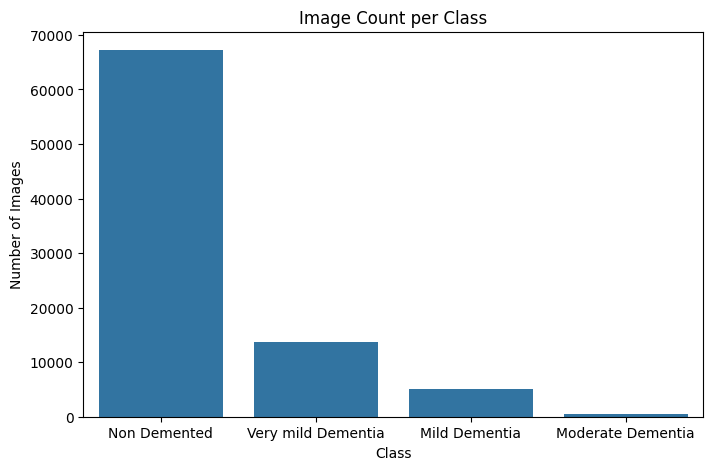

In [10]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

## Train Test split

In [11]:
import shutil

train_dir=os.path.join(data_dir, 'train')
test_dir=os.path.join(data_dir, 'test')

for cls in class_names:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

def split_and_copy(source_path, class_name, train_dest, test_dest, test_ratio=0.2):
    all_files = os.listdir(source_path)
    np.random.shuffle(all_files)

    train_files, test_files = np.split(np.array(all_files), [int(len(all_files) * (1 - test_ratio))])

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, class_name, file))
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, class_name, file))

for cls in class_names:
    split_and_copy(os.path.join(data_dir, cls), cls, train_dir, test_dir)

print("✅ Train-test split completed!")

✅ Train-test split completed!


## Data Preprocessing

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.


## visualize Augumented data

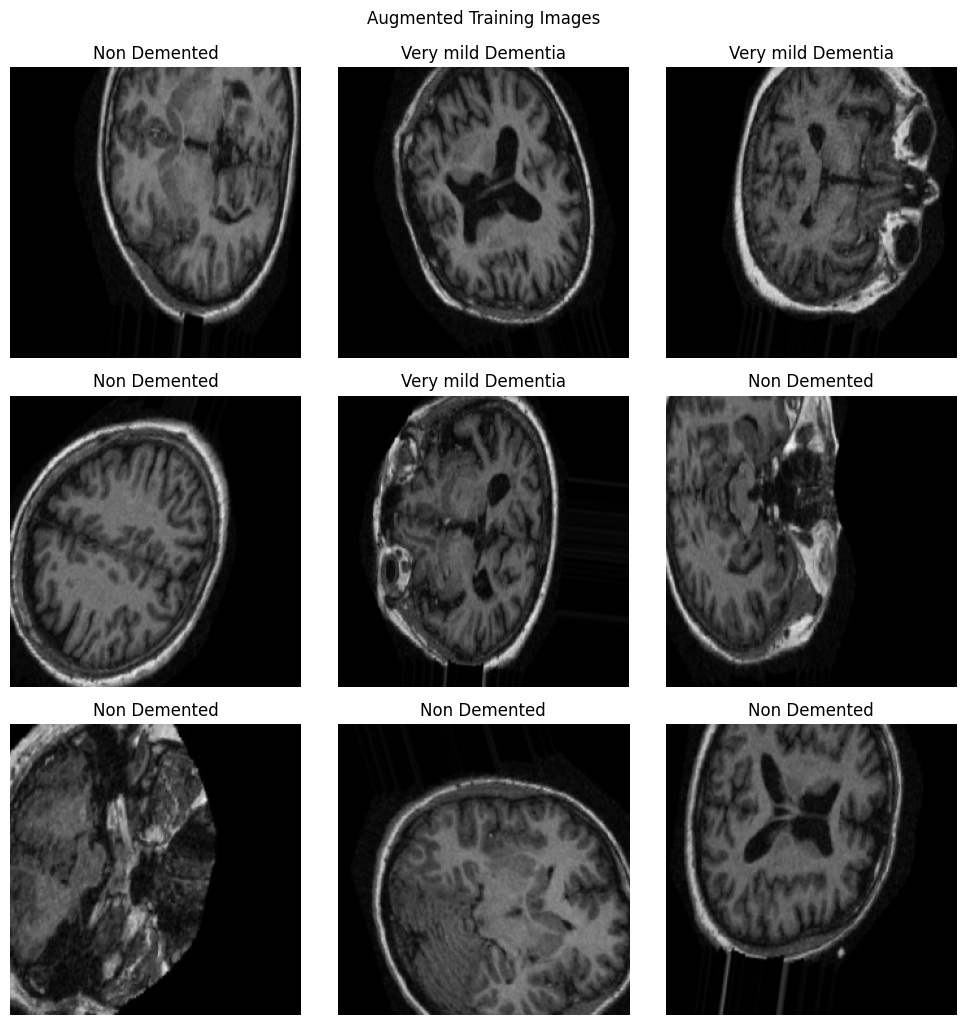

In [13]:
images, labels = next(train_generator)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Images", y=1.02)
plt.show()

## Class Distribution stats

<ipython-input-14-b4cf26ddd098>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="pastel")


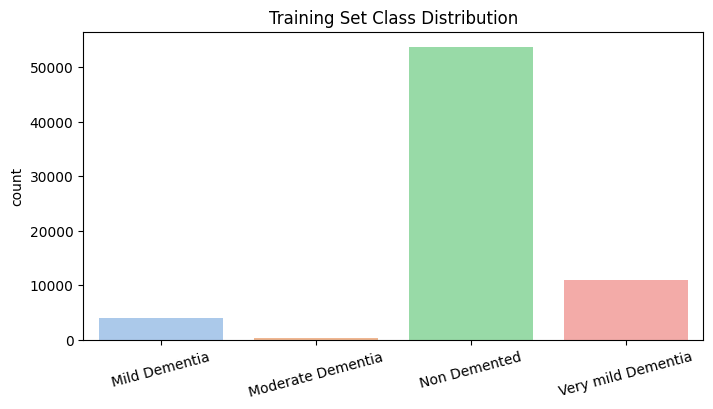

<ipython-input-14-b4cf26ddd098>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_labels, palette="pastel")


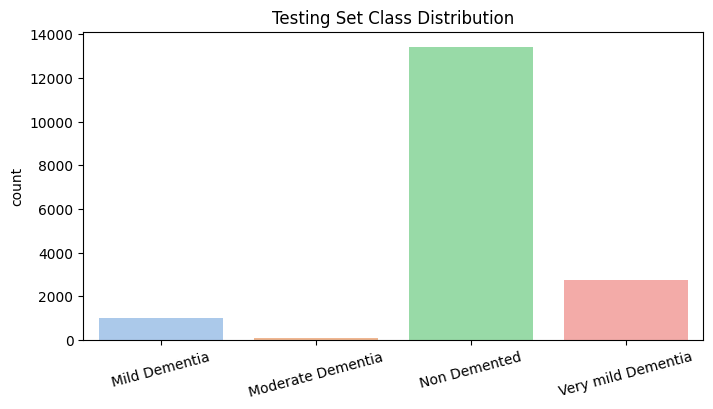

In [14]:
import pandas as pd

train_labels = [idx_to_class[c] for c in train_generator.classes]
test_labels = [idx_to_class[c] for c in test_generator.classes]

plt.figure(figsize=(8, 4))
sns.countplot(x=train_labels, palette="pastel")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=test_labels, palette="pastel")
plt.title("Testing Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

## Images height and width statistics

In [15]:
heights = image_shapes[:, 0]
widths = image_shapes[:, 1]
channels = image_shapes[:, 2]

print(f"Image Height - Mean: {np.mean(heights):.1f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
print(f"Image Width  - Mean: {np.mean(widths):.1f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Channels: {np.unique(channels)}")

Image Height - Mean: 248.0, Min: 248, Max: 248
Image Width  - Mean: 496.0, Min: 496, Max: 496
Channels: [3]


# <span style="color: red;">2- Building Fine-tuned VGG19 model using Transfer Learning</span>



Based on the paper “Deep Learning Approach for Early Detection of Alzheimer’s Disease”,

🔹 Transfer Learning (used first)
The VGG19 model was pre-trained on ImageNet — a large-scale dataset of natural images.



🔹 Fine-Tuning (also applied)
Instead of freezing all the pre-trained layers, the model was fine-tuned, meaning all layers were trainable . Fine-tuning allowed the model to adjust the pre-trained features to the new medical domain (MRI scans)

🔧 Steps done

Two-phase training:


First with the VGG base frozen (transfer learning)


Then fine-tune last 10 layers (as done in the paper)


Added callbacks like EarlyStopping for better model generalization.


Matches the exact concept used in the Alzheimer’s paper: VGG19 + Transfer Learning + Fine Tuning.

In [16]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [17]:
# Load pre-trained VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Initially freeze all layers (Transfer Learning stage)
for layer in base_model.layers:
    layer.trainable = False

In [19]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')  # 4 classes for Alzheimer's stages
])

In [20]:
# Compile (Transfer Learning)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,405,060 (177.02 MB)

 Trainable params: 26,380,676 (100.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
#  Train (Transfer Learning)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

In [21]:
# Fine-tune: Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

In [22]:
# Compile again (Fine-Tuning stage)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#  Train (Fine-Tuning)
fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1510s 680ms/step - accuracy: 0.7475 - loss: 0.6812 - val_accuracy: 0.7888 - val_loss: 0.4653
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1407s 651ms/step - accuracy: 0.7830 - loss: 0.4663 - val_accuracy: 0.8363 - val_loss: 0.3726
Epoch 3/5
 742/2161 ━━━━━━━━━━━━━━━━━━━━ 13:41 579ms/step - accuracy: 0.8053 - loss: 0.4277

In [ ]:
def plot_training(history, title='Training'):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history, 'Initial Transfer Learning')

In [ ]:
plot_training(fine_tune_history, 'Fine-Tuning')

In [ ]:
# Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

In [ ]:
# Labels
class_labels = list(test_generator.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix - Alzheimer's Classification")
plt.show()

#Lime

In [ ]:
# Install if not already done
!pip install lime shap

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pick one image from the test set
images, labels = next(test_generator)
sample_image = images[0]
sample_label = labels[0]

# Prepare LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Wrapper for model prediction
def predict_fn(images):
    return model.predict(np.array(images))

# Explain instance
explanation = explainer.explain_instance(
    sample_image.astype('double'),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Get top predicted class
pred_class = explanation.top_labels[0]

# Get image and mask
temp, mask = explanation.get_image_and_mask(
    pred_class,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Plot LIME Explanation
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME - Important Features")
plt.axis('off')

plt.subplot(1, 3, 3)
probs = model.predict(np.expand_dims(sample_image, axis=0))[0]
plt.barh(list(test_generator.class_indices.keys()), probs)
plt.title("Prediction Probabilities")
plt.tight_layout()
plt.show()

In [ ]:
# Sample background and test data
background = images[np.random.choice(images.shape[0], 50, replace=False)]
test_images = images[:5]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_images)

# Plot SHAP explanations
shap.image_plot(shap_values, test_images)


##**Problems Faced during this phase :**
The transfer Learning training part took so much long time because of the size of dataset first I made it 10 epochs and it was almost finished but unfortunately the runtime disconnected so I was forced to restart session again and all the results wer gone but it reached epoch 9 with accuracy 0.78 , then I changed it to 5 epoch but I was running out of time so the prediction and plotting and the lime i didn't have the time to run it to know the output .